In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from IPython.display import FileLink
import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
import base64
from sklearn.model_selection import GridSearchCV, PredefinedSplit
# Any results you write to the current directory are saved as output.

['__notebook__.ipynb', '__output__.json', '__results___files', 'custom.css', 'test.csv', '__results__.html', 'dftest.csv', 'dftrain.csv']


In [2]:
import sklearn
import scipy.sparse 
import lightgbm as lgb
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import gc
import psutil
import xgboost as xgb
import itertools
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import IsolationForest

In [3]:
training = pd.read_csv('../input/dftrain.csv')
testf = pd.read_csv('../input/test.csv')

### Predict

In [4]:
datasample = training
dates = datasample['date_block_num']
boolean_test = (dates.isin([22,31,32,33])) # & (boolean)
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

data1 = datasample['item_cnt_day'].clip_upper(40, inplace=True)
data1 = datasample['item_cnt_day'].clip_lower(0, inplace=True)

columns=['date_block_num']
X1     = datasample.iloc[:, datasample.columns != 'item_cnt_day']
Y1     = datasample.iloc[:, datasample.columns == 'item_cnt_day']
# the above are designed to define x and y
X_train = X1.loc[boolean_train].drop(columns, axis=1).values
X_cv =  X1.loc[boolean_test].drop(columns, axis=1).values

Y_train = Y1.loc[boolean_train].values
Y_cv =  Y1.loc[boolean_test].values
cols = list(X1.columns)

In [5]:
del datasample
del data1
del X1 
del Y1
del training

In [6]:
print('X_train shape is ' + str(X_train.shape))
print('X_cv shape is ' + str(X_cv.shape))
print('Y_train shape is ' + str(Y_train.shape))
print('Y_cv shape is ' + str(Y_cv.shape))

X_train shape is (5090285, 43)
X_cv shape is (987463, 43)
Y_train shape is (5090285, 1)
Y_cv shape is (987463, 1)


**We will train 3 different models** using grid search for hyperparameter tuning

Light GBM, RF and XGBOOST (  values of the parameters search are used from other kernels as it is extremely difficult to find hyperparameter search )

In [7]:
X = np.concatenate((X_train, X_cv), axis=0)
y = np.append(Y_train, Y_cv)

**Hyper paramter tuning and model generation**

from sklearn.metrics import mean_squared_error
learning_rates = [0.02, 0.04, 0.06, 0.08, 0.1]
best_rmse = 9999999999999
for lr in learning_rates:
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=Y_train.clip(0,40).ravel()), int(100 * (lr / 0.03)))
    pred_lgb_val = lgb_model.predict(X_cv)
    score = np.sqrt(mean_squared_error(Y_cv.clip(0.20), pred_lgb_val.clip(0,20)))
    if score < best_rmse:
        best_rmse = score
        best_lr = lr
        best_lgb = lgb_model
best_lr

#del best_lgb
del lgb_model
del score


del pred_lgb_val

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.08, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }
best_lgb = lgb.train(lgb_params, lgb.Dataset(X, label=y), int(100 * (0.05 / 0.03)))

In [8]:
import xgboost as xgb
xgbtrain = [(xgb.DMatrix(X_train, Y_train), 'train'), (xgb.DMatrix(X_cv, Y_cv), 'valid')]
param = {'max_depth':6, 
         'subsample':0.9,
         'min_child_weight':1,
         'eta':0.03, 
         'seed':3,
         'gamma':4,
         'silent':0,
         'reg_alpha':0.2,
         'eval_metric':'rmse',
         'n_estimators':100,
         'colsample_bytree': 0.4
        } # random parameters

bstxgb = xgb.train(param, xgb.DMatrix(X_train,Y_train), 500, xgbtrain, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[11:15:17] WARNING: /workspace/src/learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.42962	valid-rmse:1.49058
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.10402	valid-rmse:1.2261
[100]	train-rmse:1.05808	valid-rmse:1.18668
[150]	train-rmse:1.03716	valid-rmse:1.16694
[200]	train-rmse:1.02543	valid-rmse:1.16025
[250]	train-rmse:1.01713	valid-rmse:1.15682
[300]	train-rmse:1.00911	valid-rmse:1.15323
[350]	train-rmse:1.00293	valid-rmse:1.15006
[400]	train-rmse:0.9983	valid-rmse:1.14778
[450]	train-rmse:0.9937	valid-rmse:1.14646
[499]	train-rmse:0.989128	valid-rmse:1.1451


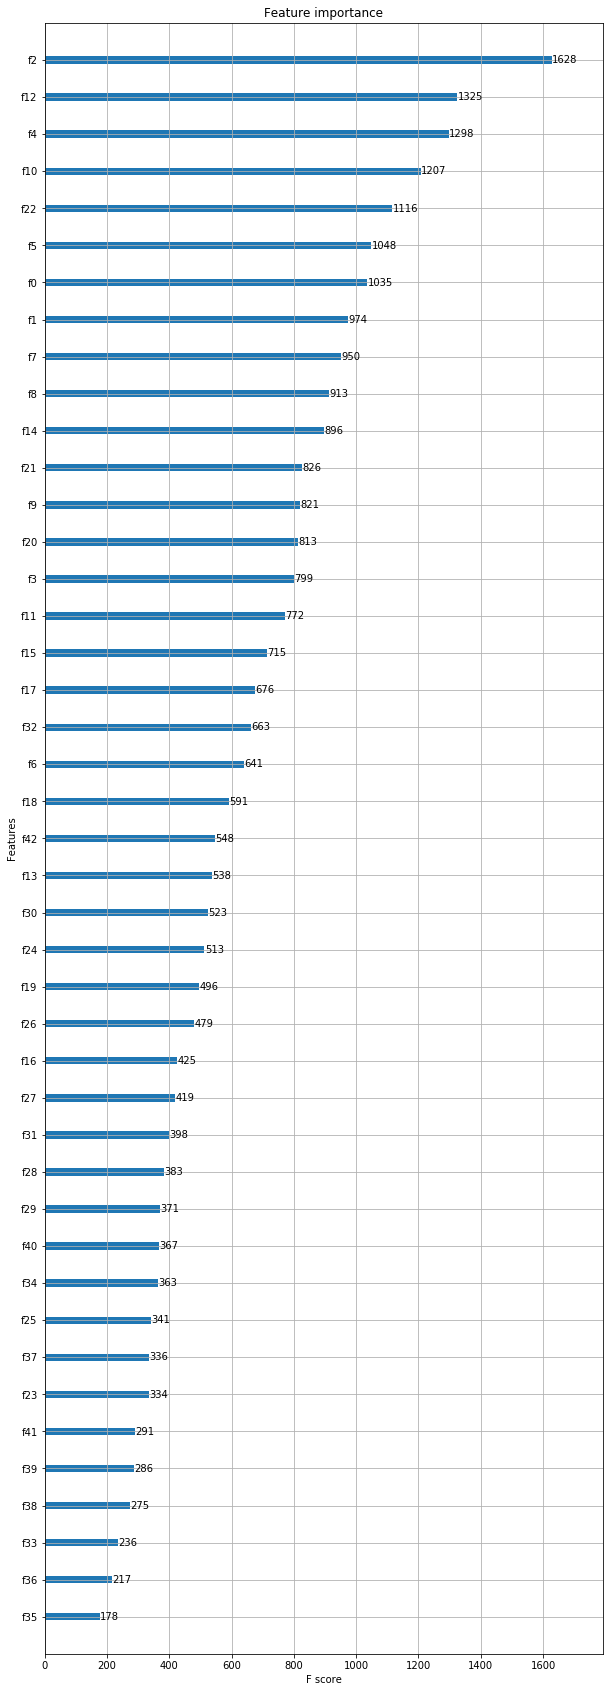

In [9]:
x=xgb.plot_importance(bstxgb)
x.figure.set_size_inches(10, 30)


In [10]:
cols1 = [cols[x] for x in [12, 4, 2]] #top columns
cols1

['item_category_id_avg_item_cnt_day_lag_1',
 'item_id_avg_item_price_lag_1',
 'date_block_num']

In [11]:
test = pd.read_csv('../input/dftest.csv')

df_ = pd.DataFrame(columns=test.columns)
df_ = df_.fillna(0)
for i in test.columns:
    for j in cols1:
        if j in i:
            df_[i] = test[j]
        else:
            df_[i]=0
df_

In [12]:
column = ['date_block_num']
#df_ = df_.drop(column, axis = 1)
test = test.drop(column, axis = 1)

In [13]:
pickle.dump(bstxgb, open("xgb.pickle.dat", "wb"))
model = pickle.load(open("xgb.pickle.dat", "rb"))

pred = model.predict(xgb.DMatrix(test.values), ntree_limit=model.best_ntree_limit)
testf['item_cnt_month'] = pred.clip(0,20)
testf.drop(['shop_id', 'item_id'], axis=1, inplace=True)
testf.to_csv('submission.csv', index=False)

In [14]:
FileLink('submission.csv')

/kaggle/working/submission.csv

In [15]:
xgbpredict1 = xgb.DMatrix(test.values)
pred_xgb_test = xgb_model.predict(xgbpredict1)

NameError: name 'xgb_model' is not defined

**grid search for rf**

train_ind=np.zeros(X.shape[0])
for i in range(0, len(X_train)):
    train_ind[i] = -1
ps = PredefinedSplit(test_fold=(train_ind))

param_grid={'bootstrap':[0.7, 0.8], 'max_features':[4, 6, 8], 
            'max_depth' : [None, 4, 6, 8, 10, 12]}
gs = GridSearchCV(cv = ps, 
                  estimator = RandomForestRegressor(n_estimators=300, n_jobs=4), 
                  param_grid=param_grid, scoring='neg_mean_squared_error')

gs.fit(X, y.clip(0,40))
best_rf = gs.best_estimator_
best_rf

rf = RandomForestRegressor(bootstrap=0.9, criterion='mse', max_depth=12,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
bst = rf.fit(X, y.ravel())

We now predict the validation parts of the data and use it and ycv to train the meta model

lgb_pkl_filename = 'lgb_20190213.pkl'
lgb_model_pkl = open(lgb_pkl_filename, 'wb')
pickle.dump(best_lgb, lgb_model_pkl)
lgb_model_pkl.close()
#xgb_pkl_filename = 'xgb_20190213.pkl'
#xgb_model_pkl = open(xgb_pkl_filename, 'wb')
#pickle.dump(bstxgb, xgb_model_pkl)
#xgb_model_pkl.close()
rf_pkl_filename = 'rf_20190213.pkl'
rf_model_pkl = open(rf_pkl_filename, 'wb')
pickle.dump(bst, rf_model_pkl)
rf_model_pkl.close()

we generate the meta parameters in the validation set

lgb_model_pkl = open(lgb_pkl_filename, 'rb')
lgb_model = pickle.load(lgb_model_pkl)
#xgb_model_pkl = open(xgb_pkl_filename, 'rb')
#xgb_model = pickle.load(xgb_model_pkl)
rf_model_pkl = open(rf_pkl_filename, 'rb')
rf_model = pickle.load(rf_model_pkl)

pred_lgb = lgb_model.predict(X_cv)
#xgbpredict = xgb.DMatrix(X_cv)
#pred_xgb = xgb_model.predict(xgbpredict)
pred_rf  = rf_model.predict(X_cv)
pred_lgb = pred_lgb.clip(0,20)
#pred_xgb = pred_xgb.clip(0,20)
pred_rf  = pred_rf.clip(0,20)

Use a metamodel to train over the generated meta parameters

#Xmeta = np.c_[pred_lgb, pred_xgb, pred_rf]
Xmeta = np.c_[pred_lgb, pred_rf]
Ymeta = Y_cv
from sklearn.linear_model import Ridge
rr = Ridge(alpha=0.1) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely

rr.fit(Xmeta, Ymeta)
rr.score(Xmeta,Ymeta)

pred_lgb_test = lgb_model.predict(test.values)
#xgbpredict1 = xgb.DMatrix(test.values)
#pred_xgb_test = xgb_model.predict(xgbpredict1)
pred_rf_test  = rf_model.predict(test.values)
pred_lgb_test1 = pred_lgb_test.clip(0,20)
#pred_xgb_test1 = pred_xgb_test.clip(0,20)
pred_rf_test1  = pred_rf_test.clip(0,20)

#test_meta = np.c_[pred_lgb_test1,pred_xgb_test1,pred_rf_test1]
test_meta = np.c_[pred_lgb_test1,pred_rf_test1]

pred_meta = rr.predict(test_meta)

pred_meta.clip(0,20)

ans_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred_meta.ravel() })

ans_df.to_csv('submission.csv',index=False)
FileLink('submission.csv')